In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
training_data_filename = './training_data_PACE.npy'

Loaded 348 entries from ./training_data_PACE.npy


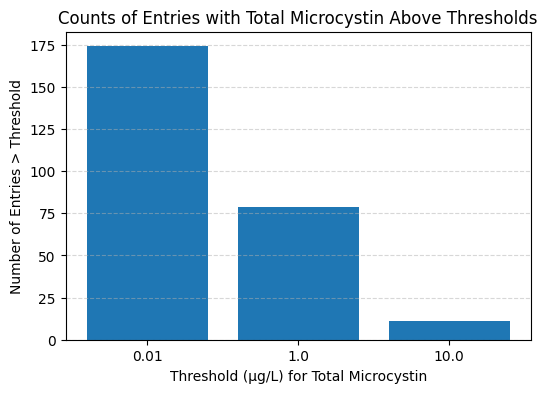

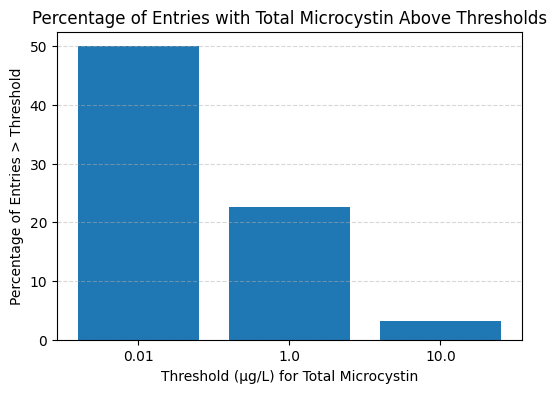

In [7]:
if not os.path.exists(training_data_filename):
    raise FileNotFoundError(f"File '{training_data_filename}' not found. Please ensure the correct path and rerun.")

# Load the training data
data = np.load(training_data_filename, allow_pickle=True)
print(f"Loaded {len(data)} entries from {training_data_filename}")

#data = np.array([entry for entry in data if entry[2][5] > 0])

# Extract total microcystin (particulate + dissolved), replacing NaN with 0
total_list = []
for entry in data:
    labels = entry[2]  # expecting [particulate, dissolved, ...]
    if labels is None or len(labels) < 2:
        # If labels missing, treat as zeros
        continue
    else:
        part = labels[4] if not np.isnan(labels[4]) else 0.0
        part = part if part != 0 else 0.01
        total_list.append(part)

total = np.array(total_list, dtype=float)

# Compute counts for thresholds
thresholds = [0.01, 1, 10]
summary = []
n_total = len(total)
for th in thresholds:
    count = np.sum(total > th)
    pct = (count / n_total) * 100 if n_total > 0 else np.nan
    summary.append({"threshold (µg/L)": th, "count > threshold": count, "percentage (%)": pct})

# Create a DataFrame for display
df_summary = pd.DataFrame(summary)

# Display the summary
import matplotlib.pyplot as plt

# Optionally, plot bar chart of counts
plt.figure(figsize=(6, 4))
plt.bar(df_summary["threshold (µg/L)"].astype(str), df_summary["count > threshold"])
plt.xlabel("Threshold (µg/L) for Total Microcystin")
plt.ylabel("Number of Entries > Threshold")
plt.title("Counts of Entries with Total Microcystin Above Thresholds")
plt.grid(axis='y', ls='--', alpha=0.5)
plt.show()

# Optionally, plot percentage
plt.figure(figsize=(6, 4))
plt.bar(df_summary["threshold (µg/L)"].astype(str), df_summary["percentage (%)"])
plt.xlabel("Threshold (µg/L) for Total Microcystin")
plt.ylabel("Percentage of Entries > Threshold")
plt.title("Percentage of Entries with Total Microcystin Above Thresholds")
plt.grid(axis='y', ls='--', alpha=0.5)
plt.show()


In [4]:
# Determine feature vector size from first entry
first_entry = data[0]
if len(first_entry) < 3:
    raise ValueError("Unexpected entry format. Each entry should be (row_index, labels_array, patch_flat_array)")
first_patch = first_entry[3]
if not isinstance(first_patch, np.ndarray):
    raise ValueError("Patch data not found or not a numpy array.")

n_samples = len(data)
n_features = first_patch.size

# Initialize feature and label arrays
X = np.zeros((n_samples, n_features), dtype=float)
y = np.zeros(n_samples, dtype=int)

# Populate X and y
for idx, entry in enumerate(data):
    _, _, labels, patch_flat = entry
    #if labels[5] < 10: continue
    # Feature: flatten reflectance array; assume consistent size
    patch_arr = patch_flat
    if patch_arr.size != n_features:
        raise ValueError(f"Inconsistent feature size at entry {idx}: expected {n_features}, got {patch_arr.size}")
    # Optionally handle NaNs in features; e.g., replace NaN with 0
    patch_arr = np.nan_to_num(patch_arr, nan=0.0)
    X[idx, :] = patch_arr

    # Label: total microcystin > 0.1 µg/L
    if labels is None or len(labels) < 2:
        total = 0.0
    else:
        part = labels[4] if not np.isnan(labels[4]) else 0.0
        part = part if part != 0 else 0.01
    y[idx] = 1 if part >= 0.1 else 0

# Display class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution (label: count):", dict(zip(unique, counts)))

# Save feature and label arrays if desired
np.save("X.npy", X)
np.save("y.npy", y)
print(f"Saved features to X.npy and labels to y.npy. X shape: {X.shape}, y shape: {y.shape}")


Class distribution (label: count): {np.int64(0): np.int64(59), np.int64(1): np.int64(172)}
Saved features to X.npy and labels to y.npy. X shape: (231, 4300), y shape: (231,)


In [ ]:
# Assuming your array is named `data_array`
rows = []
for row in data:
    label_tuple = row[2]  # This is the 6-element tuple
    timestamp = label_tuple[1]
    particulate_microcystin = label_tuple[4]
    extracted_chla = label_tuple[5]
    rows.append({
        'datetime': timestamp,
        'particulate_microcystin': particulate_microcystin,
        'extracted_chla': extracted_chla
    })

df = pd.DataFrame(rows)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by = 'datetime')
df

In [ ]:
df.loc[df['particulate_microcystin'] < 0.1, 'particulate_microcystin'] = 0

In [ ]:
# Assuming df is the DataFrame you already created:
# Columns: ['datetime', 'particulate_microcystin', 'extracted_chla']
plot_df = df[df['datetime'] > pd.to_datetime('2022-06-01', utc = True)]
plot_df = plot_df[plot_df['datetime'] < pd.to_datetime('2022-11-01', utc = True)]
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot particulate_microcystin on left y-axis
color1 = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Particulate Microcystin (µg/L)', color=color1)
ax1.plot(plot_df['datetime'], plot_df['particulate_microcystin'], color=color1, label='Particulate Microcystin')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Extracted Chl-a (µg/L)', color=color2)
ax2.plot(plot_df['datetime'], plot_df['extracted_chla'], color=color2, label='Extracted Chl-a', alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Particulate Microcystin and Extracted Chl-a Over Time')
fig.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Filter DataFrame
filtered_df = df[df['particulate_microcystin'] >= 0]
filtered_df = filtered_df[filtered_df['extracted_chla'] < 20]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(filtered_df['extracted_chla'].dropna(), bins=30, color='tab:green', edgecolor='black')

# Labels and title
plt.xlabel('Extracted Chl-a (µg/L)')
plt.ylabel('Frequency')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
data